In [1]:
%matplotlib inline
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

In [2]:
from scipy.spatial import distance

class Data(object):
    # N points, k cluster, p dimensions
    def __init__(self, N, k, p):
        self.N = N
        self.k = k
        self.p = p
        self.true_center = []
        self.true_cluster_list = []
        self.data_set = []
        self.PIs = []
        self.means = []
        self.sigma = 0.0

    def init_board_gauss(self):
        n = float(self.N)/self.k
        X = []
        for i in range(self.k):
            c = ()
            # construct a random center point
            for j in range(self.p):
                c = c + (random.uniform(-1,1),)
            self.true_center.append(c)
            #s = random.uniform(0.05,0.5)
            s = 0.05
            x = []
            while len(x) < n:
                # need to change dimension
                lst = []
                for i in c:
                    lst.append(np.random.normal(i,s))
                point = np.array(lst)
                good = True
                for i in point:
                    if abs(i) >= 1:
                        good = False
                if good:
                    x.append(point)
            X.extend(x)
        X = np.array(X)[:self.N]
        return X

    def set_data(self, data):
        self.data_set = data
    # Taking in true center list, and the result center list
    def error_calculate(self,res):
        error = 0.0
        for i in range(self.k):
            min_dis = distance.euclidean(self.true_center[i],res[0])
            for j in range(self.k):
                # calculate the distance btw true center and kmean center
                dst = distance.euclidean(self.true_center[i],res[j])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            error += min_dis * min_dis
        # print "the error rate is: ", error
        return math.sqrt(error / (self.sigma * self.sigma * self.p))

    # calculate the true function enables more kmean center than true center
    # this is for the true center 
    def true_cost_function(self):
        cost = 0.0
        # loop through the data set
        for data in self.data_set:
            # min_dist is the distance to the first true center
            min_dis = distance.euclidean(data,self.true_center[0])
            # loop through the true center
            for i in range(self.k):
                 # calculate the distance btw true center and kmean center
                dst = distance.euclidean(data,self.true_center[i])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            cost += min_dis * min_dis
        return cost
    
    # this is for the cost function compared to the true center cost function
    def cost_function(self,res):
        cost = 0.0
        # loop through the whole dataset
        for data in self.data_set:
            min_dis = distance.euclidean(data,res[0])
            for i in range(len(res)):
                 # calculate the distance btw true center and kmean center
                dst = distance.euclidean(data,res[i])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            cost += min_dis * min_dis
        # the ratio of result center cost/ true center cost
        return cost/self.true_cost_function()
            

    def set_true_center(self, means):
        self.true_center = means

    # mean is a p dimensional vector, covarience is a p*p matrix
    # number_of_sample is n samples
    # return value: n*p matrix, generate n samples from N(mean,covarience)
    def generate_mult_normal_data(self, mean, covariance, num_of_samples):
        return np.random.multivariate_normal(mean,covariance, num_of_samples)

    # prob is list of probability that sums to 1
    # means is a p dimensional vector,covarience is a p*p matrix
    # number_of_samples is n samples
    # return value: generate n samples from the mixture of Gaussian
    def generate_mult_normal_based_prob(self, prob, means, covariance, num_of_samples):
        data_list = []
        # keep track which points belong to which cluster
        true_cluster_list = []
        for i in range(num_of_samples):
            # flip a coin to see which cluster the data point comes from
            random_num = random.random()
            sum = 0.0
            index = -1
            for p in prob:
                if random_num < sum:
                    break
                sum += p
                index = index + 1
            true_cluster_list.append(index)
            # call the generate_mult_normal_data rountine
            data_list.append(self.generate_mult_normal_data(means[index], covariance,1)[0])
        self.true_cluster_list = true_cluster_list
        return np.array(data_list)[:num_of_samples]
        #return (np.array(data_list)[:num_of_samples], true_cluster_list)
    def generate_data(self, dimension, p_sigma, number_of_cluster, number_of_points):
        # dimension
        self.p = dimension

        # sqrt of variance
        self.sigma = p_sigma

        # k is number of clusters
        self.k = number_of_cluster

        # n is number of points to be generated
        self.N = number_of_points

        # init a covariance matrix as identity matrix
        self.identity_matrix = np.identity(self.p)

        # covariance matrix
        covariance = self.sigma * self.sigma * self.identity_matrix
        # choose means from


        # means are from a normal distribution with center is all 0s and varience N(0,sigma squre identity matrix)
        mean = []
        for i in range(self.p):
            mean.append(0)
        # choose means, k is the number of centers/cluster
        self.means = self.generate_mult_normal_data(mean, covariance, self.k)

        self.set_true_center(self.means)

        # choose pis, ASA probabolity
        self.PIs = []
        for i in range(self.k):
            # every cluster has the same probability
            self.PIs.append(1.0/self.k)

        # generate n points from the mixture model
        self.data_set = self.generate_mult_normal_based_prob(self.PIs, self.means, covariance, self.N)

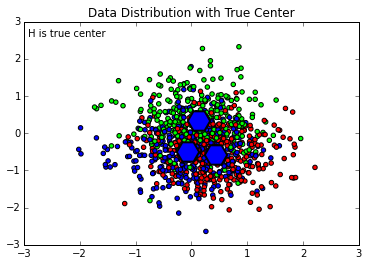

In [3]:
import random
import pylab
#color list
color_list = ([1,0,0],[0,1,0],[0,0,1],[1,1,0],[0,1,1],[1,1,0.7],[0.7,1,0],[1,0,0.7],[0.5,0.5,0], [0.5, 0, 0.5])

# create a data object
# number of points, k clusters, p dimensions
d = Data(1000, 3, 3)
# dimesion, sigma, cluster, # of points
d.generate_data(3, 0.6, 3, 1000)

# true center with true cluster
colors = ([color_list[i] for i in d.true_cluster_list])
pylab.scatter(d.data_set[:,0],d.data_set[:,1], c=colors)
pylab.title("Data Distribution with True Center")
pylab.figtext(0.135,0.85,'H is true center')
# hetagon means true center
pylab.scatter(d.true_center[:,0],d.true_center[:,1], marker='H', s = 500, linewidths=2)
pylab.show()
pylab.clf()

number of estimated clusters : 3


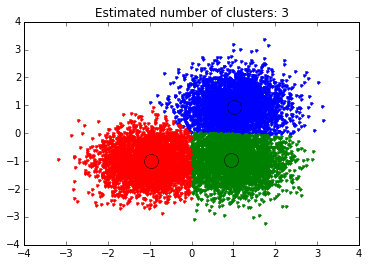

In [4]:
###############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]

X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

###############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
# estimate on Data d

bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=10000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

###############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [5]:
def K_Nearest_Neighbor(current, k, data):
    return_list = []
    index = 0
    distanceList = []
    for x in data:
        distanceList.append((distance.euclidean(current, x), x))
    distanceList.sort(key=lambda tup: tup[0])  # sorts in place
    #get the k nearest label
    for i in range (0, k):
        #append the first k smallest element
        return_list.append(distanceList[i][1])
    return return_list
# implement simple mean shift

import numpy as np

mu, sigma = 10, 5 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
#print s
s.sort()


In [6]:
from random import randrange

# Assume data is already in np.array
def mean_shift(data, window_size, k):
    threshold = 0.00001

    # indicate how many neighbors to look
    number_of_neighbors = window_size
    mean_list = []
    # random choose k points
    for i in range(0, k):
        random_index = randrange(0,len(data))
        mean_list.append(data[random_index])
    # while less than threshold
    iteration = 0
    result = []
    new_list = mean_list
    prev_list = [np.array([0]*len(data[0]))] * len(mean_list)
    current_list = [np.array([1000]*len(data[0]))] * len(mean_list)

    converged = False
    while not converged:
        # left 10 points include itself
        mean_list = new_list
        new_list = []
        if len(mean_list) == 0:
            break
        iteration = iteration + 1
        converged = True
        for j in range(0, len(mean_list)):
            count = 0 # count how many points added to the mean
            lst = K_Nearest_Neighbor(mean_list[j],number_of_neighbors, data)
            mean = 0.0
            for i in lst:
                mean = mean + i
                count = count + 1
            # update mean
            mean = mean/count
            if distance.euclidean(mean_list[j], mean) > threshold:
                converged = False
            prev_list[j] = current_list[j]
            current_list[j] = mean
            # condition for converged
            if abs(distance.euclidean(current_list[j],prev_list[j])) < threshold:
                result.append(current_list[j])
            else:
                new_list.append(current_list[j])
        print iteration
    #     print "current is ", current
    #     print "prev is ", prev
    print "number of iterations ", iteration    
    # print "converged mode is ", current_list
    return current_list

finish fetching data


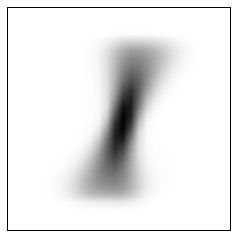

In [9]:
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
mnist = fetch_mldata('MNIST original', data_home='./data')
print "finish fetching data"
X_digits, _,_, Y_digits = mnist.values() # fetch dataset from internet
images0 = []
images1 = []
images2 = []
images3 = []
images4 = []
images5 = []
images6 = []
images7 = []
images8 = []
images9 = []
for i in range(len(Y_digits)):
    if Y_digits[i] == 0.0:
        images0.append(X_digits[i])
    elif Y_digits[i] == 1.0:
        images1.append(X_digits[i])
    elif Y_digits[i] == 2.0:
        images2.append(X_digits[i])
    elif Y_digits[i] == 3.0:
        images3.append(X_digits[i])
    elif Y_digits[i] == 4.0:
        images4.append(X_digits[i])
    elif Y_digits[i] == 5.0:
        images5.append(X_digits[i])
    elif Y_digits[i] == 6.0:
        images6.append(X_digits[i])
    elif Y_digits[i] == 7.0:
        images7.append(X_digits[i])
    elif Y_digits[i] == 8.0:
        images8.append(X_digits[i])
    elif Y_digits[i] == 9.0:
        images9.append(X_digits[i])
mnist_true_center1 = []
mnist_true_center = []
mnist_true_center.append(np.array(images0).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images1).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images2).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images3).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images4).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images5).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images6).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images7).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images8).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images9).mean(axis=0).reshape(28,28))

mnist_true_center1.append(np.array(images0).mean(axis=0))
mnist_true_center1.append(np.array(images1).mean(axis=0))
mnist_true_center1.append(np.array(images2).mean(axis=0))
mnist_true_center1.append(np.array(images3).mean(axis=0))
mnist_true_center1.append(np.array(images4).mean(axis=0))
mnist_true_center1.append(np.array(images5).mean(axis=0))
mnist_true_center1.append(np.array(images6).mean(axis=0))
mnist_true_center1.append(np.array(images7).mean(axis=0))
mnist_true_center1.append(np.array(images8).mean(axis=0))
mnist_true_center1.append(np.array(images9).mean(axis=0))

plt.rc("image", cmap="binary")
plt.imshow(mnist_true_center1[1].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()

# for i in mnist_true_center1:
#     plt.rc("image", cmap="binary")
#     # Display distribution of data from the center
#     plt.imshow(i.reshape(28,28))
#     plt.xticks(())
#     plt.yticks(())
#     plt.show()




In [8]:
partial = X_digits[-5000:]
tmp = mean_shift(partial, 500)
for i in tmp:
    plt.rc("image", cmap="binary")
    plt.imshow(i.reshape(28,28))
    plt.xticks(())
    plt.yticks(())
    plt.show()


NameError: name 'X_digits' is not defined

In [10]:
tmp = mean_shift(images1,200)
import matplotlib.pyplot as plt
plt.rc("image", cmap="binary")
plt.imshow(tmp[0].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
# for image in tmp:
#     plt.rc("image", cmap="binary")
#     plt.imshow(image.reshape(28,28))
#     plt.xticks(())
#     plt.yticks(())
#     plt.show()

TypeError: mean_shift() takes exactly 3 arguments (2 given)

In [11]:
tmp = mean_shift(images1,100)
import matplotlib.pyplot as plt
plt.rc("image", cmap="binary")
plt.imshow(tmp[0].reshape(28,28))
plt.xticks(())
plt.yticks(())
plt.show()
# for image in tmp:
#     plt.rc("image", cmap="binary")
#     plt.imshow(image.reshape(28,28))
#     plt.xticks(())
#     plt.yticks(())
#     plt.show()

TypeError: mean_shift() takes exactly 3 arguments (2 given)

In [ ]:
import matplotlib.pyplot as plt
x,y = np.random.multivariate_normal(mean,cov,5000).T
plt.plot(x,y,'x'); plt.axis('equal'); plt.show()
mean = [0,0] 
cov = [[1,0],[0,1]] # diagonal covariance, points lie on x or y-axis
data_set = np.random.multivariate_normal(mean,cov,5000)
mean_shift(data_set, 250)

In [ ]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()
mean_shift(s, 500)

In [52]:
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
mnist = fetch_mldata('MNIST original', data_home='./data')
print "finish fetching data"
X_digits, _,_, Y_digits = mnist.values() # fetch dataset from internet

finish fetching data
